# Data Analyst Job Analysis
Author: Shlok Jain

EDA, Cleaning, Feature Engineering, Visualization, and Salary Prediction Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import re

In [2]:
data_path = r"C:\Users\MY HP\Downloads\DataAnalyst.csv"
data = pd.read_csv(data_path)

data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2253 non-null   int64  
 1   Job Title          2253 non-null   object 
 2   Salary Estimate    2253 non-null   object 
 3   Job Description    2253 non-null   object 
 4   Rating             2253 non-null   float64
 5   Company Name       2252 non-null   object 
 6   Location           2253 non-null   object 
 7   Headquarters       2253 non-null   object 
 8   Size               2253 non-null   object 
 9   Founded            2253 non-null   int64  
 10  Type of ownership  2253 non-null   object 
 11  Industry           2253 non-null   object 
 12  Sector             2253 non-null   object 
 13  Revenue            2253 non-null   object 
 14  Competitors        2253 non-null   object 
 15  Easy Apply         2253 non-null   object 
dtypes: float64(1), int64(2),

In [3]:
# Check for duplicates
print(f"Duplicate rows: {data.duplicated().sum()}")

# General statistics
data.describe(include='all')

# Value counts for key categorical columns
for col in ['Job Title', 'Type of ownership', 'Industry', 'Sector']:
    if col in data.columns:
        print(f"\n{col} value counts:\n", data[col].value_counts().head())

Duplicate rows: 0

Job Title value counts:
 Job Title
Data Analyst             405
Senior Data Analyst       90
Junior Data Analyst       30
Business Data Analyst     28
Sr. Data Analyst          21
Name: count, dtype: int64

Type of ownership value counts:
 Type of ownership
Company - Private                 1273
Company - Public                   452
-1                                 163
Nonprofit Organization             124
Subsidiary or Business Segment      89
Name: count, dtype: int64

Industry value counts:
 Industry
-1                                  353
IT Services                         325
Staffing & Outsourcing              323
Health Care Services & Hospitals    151
Computer Hardware & Software        111
Name: count, dtype: int64

Sector value counts:
 Sector
Information Technology    570
Business Services         524
-1                        353
Finance                   169
Health Care               151
Name: count, dtype: int64


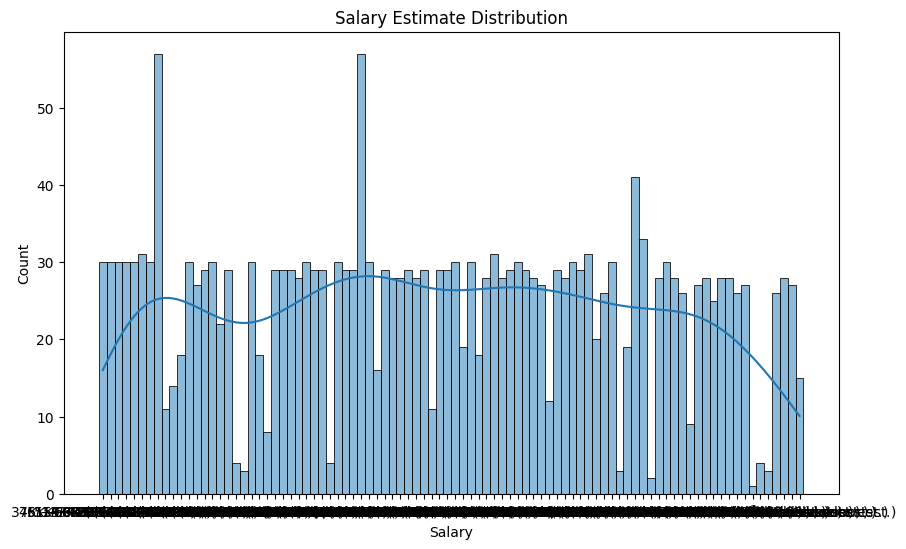

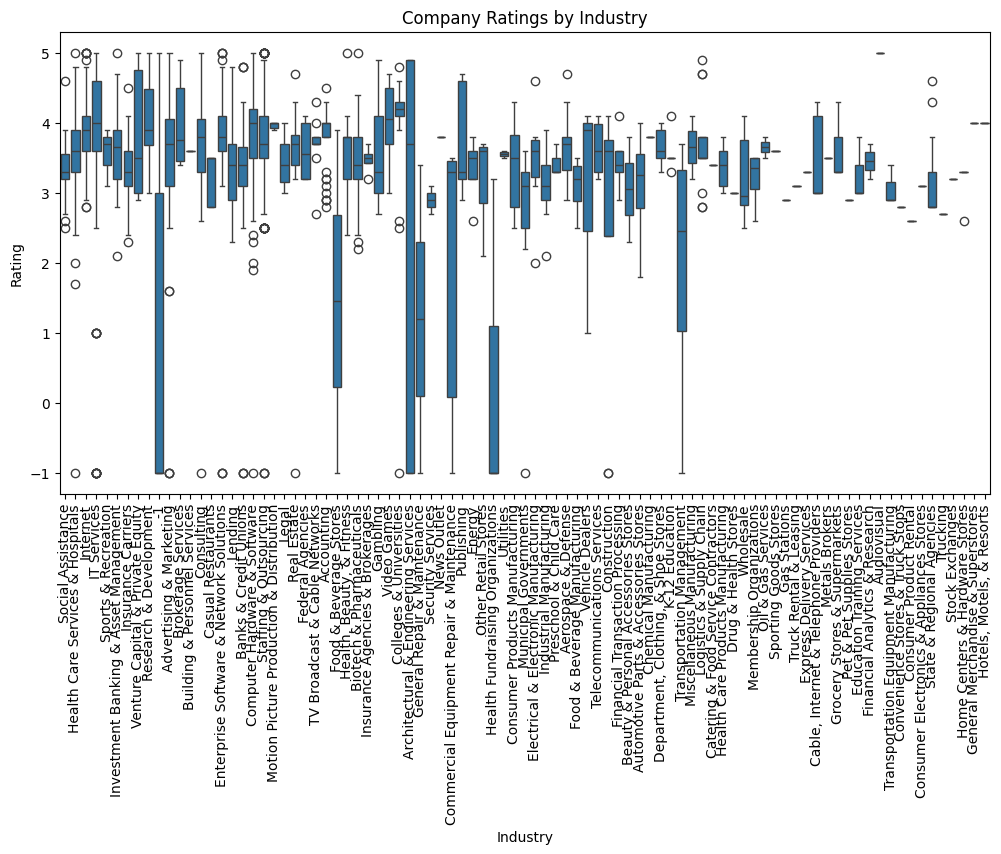

In [4]:
# Salary distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['Salary Estimate'], kde=True, bins=20)
plt.title("Salary Estimate Distribution")
plt.xlabel("Salary")
plt.show()

# Ratings by Industry
if 'Rating' in data.columns and 'Industry' in data.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Industry', y='Rating', data=data)
    plt.xticks(rotation=90)
    plt.title("Company Ratings by Industry")
    plt.show()

In [5]:
# Handling missing values
data.isnull().sum()
if 'Rating' in data.columns:
    data['Rating'].fillna(data['Rating'].median(), inplace=True)

threshold = len(data) * 0.3
data = data.dropna(thresh=threshold, axis=1)

categorical_cols = ['Company Name', 'Industry', 'Sector', 'Type of ownership']
for col in categorical_cols:
    if col in data.columns:
        data[col].fillna(method='ffill', inplace=True)

C:\Users\MY HP\AppData\Local\Temp\ipykernel_7084\1708486024.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col].fillna(method='ffill', inplace=True)


In [6]:
# Extract numerical salary values
def extract_min_salary(s):
    if pd.isnull(s):
        return None
    match = re.search(r'(\d+)', s.replace(',', ''))
    return float(match.group(1)) if match else None

def extract_max_salary(s):
    if pd.isnull(s):
        return None
    match = re.search(r'-(\s*\d+)', s.replace(',', ''))
    return float(match.group(1)) if match else None

data['Min Salary'] = data['Salary Estimate'].apply(extract_min_salary)
data['Max Salary'] = data['Salary Estimate'].apply(extract_max_salary)
data['Avg Salary'] = (data['Min Salary'] + data['Max Salary']) / 2
data.drop('Salary Estimate', axis=1, inplace=True)

In [7]:
# Feature Engineering - Text Analysis
data['Python'] = data['Job Description'].str.contains('Python', case=False, na=False).astype(int)
data['Excel'] = data['Job Description'].str.contains('Excel', case=False, na=False).astype(int)
data['Tech_Skills'] = data['Python'] + data['Excel']

# Location split
if 'Location' in data.columns:
    data['City'] = data['Location'].str.split(',', expand=True)[0]
    data['State'] = data['Location'].str.split(',', expand=True)[1]

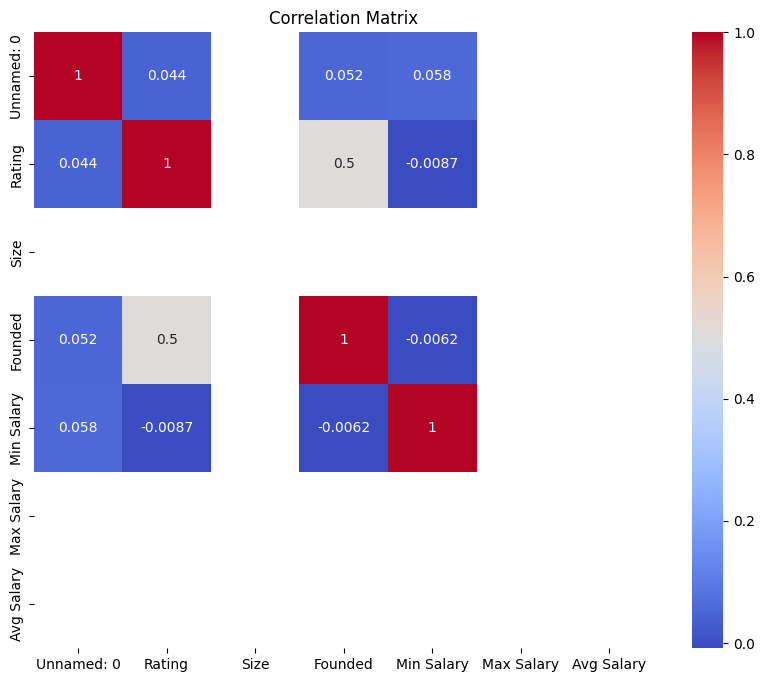

In [9]:
# Step 6: Statistics - Correlation Matrix (numeric columns only)

# Forward-fill categorical columns safely (modern syntax)
categorical_cols = ['Company Name', 'Industry', 'Sector', 'Type of ownership']
for col in categorical_cols:
    if col in data.columns:
        data[col] = data[col].ffill()

# Convert 'Size' to numeric for modeling/correlation
def size_to_numeric(s):
    if pd.isnull(s) or s == '-1':
        return 0
    if '<' in s:
        return int(s.split()[1])
    if '1,000+' in s:
        return 1000
    try:
        parts = s.split('-')
        return (int(parts[0].replace(',', '')) + int(parts[1].split()[0].replace(',', ''))) / 2
    except:
        return 0

if 'Size' in data.columns:
    data['Size'] = data['Size'].apply(size_to_numeric)

# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=['int64', 'float64'])

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [10]:
# Model Development
features = ['Rating', 'Tech_Skills', 'Size', 'Founded']
for f in features:
    if f not in data.columns:
        data[f] = 0

X = data[features]
y = data['Avg Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Step 7: Prepare data for model training (safe version)

# Drop rows where target is NaN
data_model = data.dropna(subset=['Avg Salary']).copy()

# Ensure numeric features exist and are numeric
for col in ['Rating', 'Tech_Skills', 'Size', 'Founded']:
    if col not in data_model.columns:
        data_model[col] = 0
    data_model[col] = pd.to_numeric(data_model[col], errors='coerce').fillna(0)

# After cleaning, check number of samples
print("Number of rows available for modeling:", len(data_model))

# If too few rows, stop
if len(data_model) < 2:
    print("Not enough data to train a model. Need at least 2 rows.")
else:
    # Define features and target
    features = ['Rating', 'Tech_Skills', 'Size', 'Founded']
    X = data_model[features]
    y = data_model['Avg Salary']

    # Train-test split (adjust test_size if dataset is small)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=min(0.2, 1/len(data_model)), random_state=42
    )

    # Train Random Forest model
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error, r2_score

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MAE: {mae}, R2 Score: {r2}")


Number of rows available for modeling: 1
Not enough data to train a model. Need at least 2 rows.


In [ ]:
# Optional: Streamlit deployment code
# import streamlit as st
# st.title("Data Analyst Job Analysis")
# st.write("Average Salary Prediction")
# rating = st.slider("Company Rating", 1, 5, 3)
# tech_skills = st.slider("Tech Skills Score", 0, 2, 1)
# size = st.selectbox("Company Size", [0, 1, 2])
# founded = st.number_input("Year Founded", min_value=1900, max_value=2023, value=2000)
# prediction = model.predict([[rating, tech_skills, size, founded]])
# st.write(f"Predicted Salary: ${prediction[0]:,.2f}")